In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
df = pd.read_csv("cities.csv")
df["date"] = pd.to_datetime(df["date"])

Şehir adı:  Ankara
Tahmin tipi (günlük/aylık):  aylık
Tahmin yapılacak ayı gir (YYYY-MM):  2025-06


city: Ankara
tahmin_tipi: aylık
df_city satır sayısı: 1978
ts son 5: date
2025-01-31     3.660645
2025-02-28     0.654643
2025-03-31    10.779355
2025-04-30    10.424000
2025-05-31    16.826452
Freq: ME, Name: daily_avg_temp, dtype: float64
son_tarih: 2025-05-31 00:00:00
tahmin yapılacak tarih: 2025-06-01 00:00:00
adim (steps): 1


C:\Users\Ceren\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Users\Ceren\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Tahmin uzunluğu: 1
Tarih uzunluğu: 1
Ankara için aylık SARIMA tahminleri:
1. 2025-06-30 → 20.71 °C


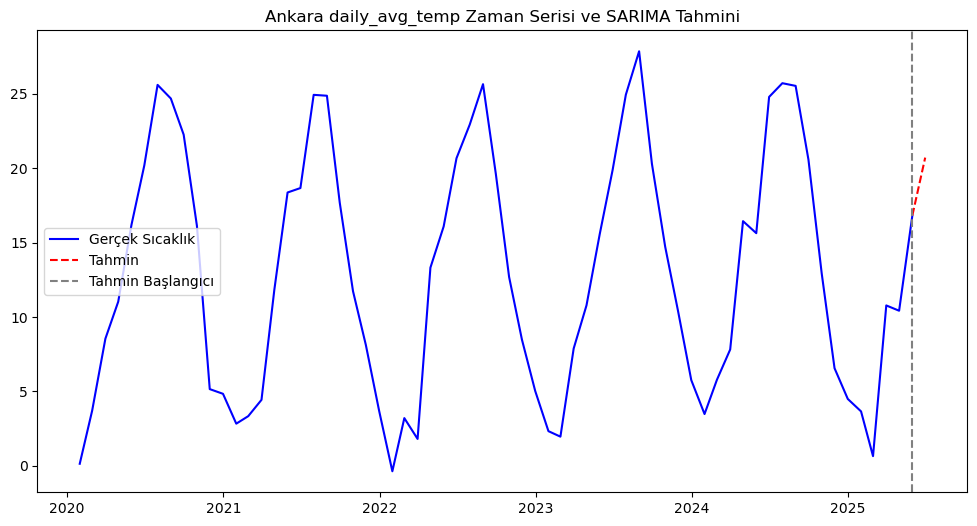

In [15]:
city = input("Şehir adı: ").strip()
tahmin_tipi = input("Tahmin tipi (günlük/aylık): ").strip().lower()

if tahmin_tipi == "günlük":
    tarih_input = input("Tahmin yapılacak günü gir (YYYY-MM-DD): ")
    tarih_sec = pd.to_datetime(tarih_input)
elif tahmin_tipi == "aylık":
    tarih_input = input("Tahmin yapılacak ayı gir (YYYY-MM): ")
    tarih_sec = pd.to_datetime(tarih_input + "-01")
else:
    raise ValueError("Tahmin tipi yanlış!")

sicaklik_tip = "daily_avg_temp"
df_city = df[df["city_name"].str.lower() == city.lower()]
if df_city.empty:
    raise ValueError(f"{city} için veri yok!")

if tahmin_tipi == "aylık":
    ts = df_city.set_index("date")[sicaklik_tip].resample("ME").mean()
    seasonality = 12
    freq = "ME"
elif tahmin_tipi == "günlük":
    # SADECE SON 30 GÜN:
    ts = df_city.set_index("date")[sicaklik_tip].asfreq("D")
    ts = ts.interpolate(method="time")
    ts = ts.dropna()
    ts = ts.tail(30)   # sadece son 30 gün
    seasonality = 7    # Günlükte sezonluk haftalık tutulabilir (çok kısa olduğu için)
    freq = "D"
else:
    raise ValueError("Tahmin tipi yanlış!")

ts = ts.dropna()  ## Son bir kez daha eksik veriler temizleniyor
son_tarih = ts.index[-1] ## Zaman serisinin en son tarihi alınır

if tahmin_tipi == "aylık":
    adim = ((tarih_sec.year - son_tarih.year) * 12 + (tarih_sec.month - son_tarih.month)) # # Aylık tahminlerde ay farkı hesaplanır (yıl farkı da dahil)
elif tahmin_tipi == "günlük":
    adim = (tarih_sec - son_tarih).days # # Günlük tahminlerde gün farkı alınır
else:
    adim = 1
if adim < 1:  
    raise ValueError("Tahmin yapılacak tarih, verideki son tarihten ileri olmalı!")

print("city:", city)
print("tahmin_tipi:", tahmin_tipi)
print("df_city satır sayısı:", len(df_city))
print("ts son 5:", ts.tail())
print("son_tarih:", son_tarih)
print("tahmin yapılacak tarih:", tarih_sec)
print("adim (steps):", adim)

model = SARIMAX(ts, order=(1,1,1), seasonal_order=(1,1,1,seasonality))
model_fit = model.fit(disp=False)

tahmin = model_fit.forecast(steps=adim)
tahmin_tarihleri = pd.date_range(son_tarih, periods=adim+1, freq=freq)[1:]
#freq, kaç günlük/aylık tahmin yapılacağını belirler. Her adımda 1 gün veya 1 ay ileri git!

## Tahmin edilen tarihler oluşturulur (ilk gün zaten elimizde olduğundan 1. indexten alınır)

print("Tahmin uzunluğu:", len(tahmin))
print("Tarih uzunluğu:", len(tahmin_tarihleri))

print(f"{city} için {tahmin_tipi} SARIMA tahminleri:")
for i, (tarih, temp) in enumerate(zip(tahmin_tarihleri, tahmin)):
    print(f"{i+1}. {tarih.date()} → {temp:.2f} °C")

plt.figure(figsize=(12,6))
plt.plot(ts, label="Gerçek Sıcaklık", color="blue")
plt.plot([ts.index[-1]] + list(tahmin_tarihleri), [ts.iloc[-1]] + list(tahmin), "r--", label="Tahmin")
plt.axvline(ts.index[-1], color="gray", linestyle="--", label="Tahmin Başlangıcı")
plt.legend()
plt.title(f"{city} {sicaklik_tip} Zaman Serisi ve SARIMA Tahmini")
plt.show()


Eğitim dönemi son tarih: 2024-05-31 00:00:00
Test dönemi tarihler: 2024-06-30 00:00:00 - 2025-05-31 00:00:00

Karşılaştırma Tablosu:
                Gerçek     Tahmin
date                            
2024-06-30  24.787333  22.604984
2024-07-31  25.709677  26.328016
2024-08-31  25.529032  27.975349
2024-09-30  20.570667  21.940500
2024-10-31  12.929355  15.911908
2024-11-30   6.562000  10.138981
2024-12-31   4.497097   6.975504
2025-01-31   3.660645   3.809498
2025-02-28   0.654643   5.797289
2025-03-31  10.779355   8.286466
2025-04-30  10.424000  15.019510
2025-05-31  16.826452  18.238962

Test dönemi RMSE: 2.838


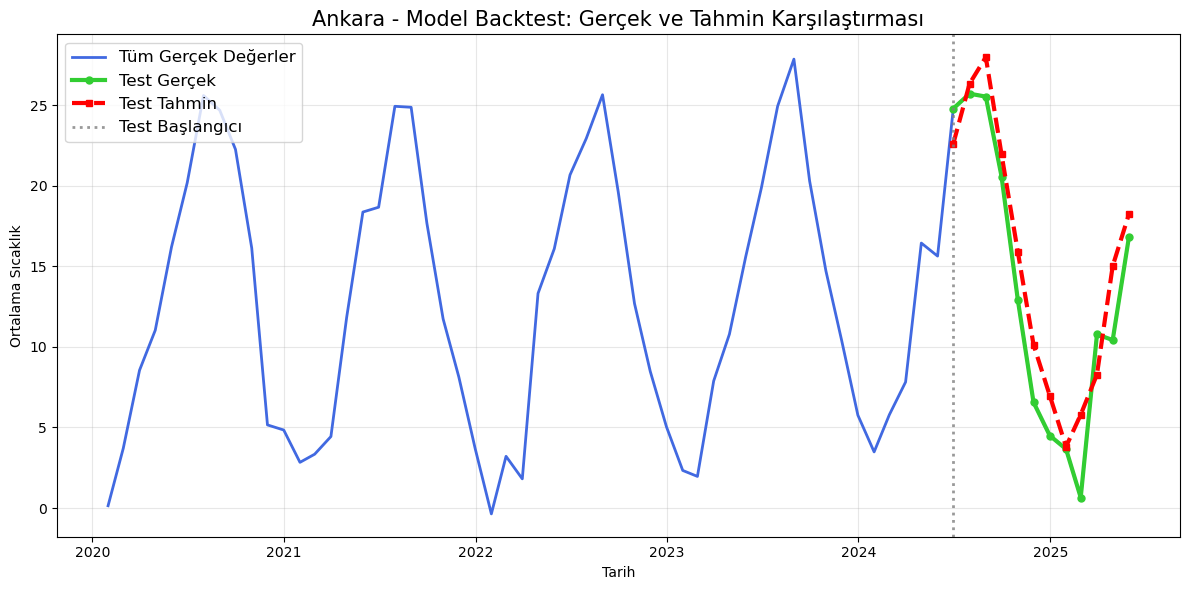

In [14]:

#city = input("Şehir adı: ").strip()
#tahmin_tipi = input("Tahmin tipi (günlük/aylık): ").strip().lower()

sicaklik_tip = "daily_avg_temp"
df_city = df[df["city_name"].str.lower() == city.lower()] #Şehre göre filtrelenmiş alt DataFrame oluşturuluyor

if tahmin_tipi == "aylık":
    ts = df_city.set_index("date")[sicaklik_tip].resample("ME").mean() #resample("M") ile aylık ortalamaya çevriliyor.
    seasonality = 12
    test_sayi = 12  # Son 12 ay test olacak
elif tahmin_tipi == "günlük":
    ts = df_city.set_index("date")[sicaklik_tip].asfreq("D").interpolate(method="time") #Veri günlük frekansa çekiliyor (asfreq("D"))
    ts = ts.dropna()
    # AYKIRI DEĞER TEMİZLİĞİ
    ts = ts[(ts > 5) & (ts < 20)]  # 5 ile 20 derece arası filtrele
    ts = ts.dropna()

    ts = ts.tail(60)  # Son 60 gün (30 eğitim, 30 test)
    seasonality = 7   # Günlükte kısa sezon (haftalık döngü önerilir)
    test_sayi = 30    # Son 30 gün test olacak

else:
    raise ValueError("Tahmin tipi yanlış!")

ts = ts.dropna()

#  eğitim ve test setleri 
egitim = ts[:-test_sayi]
test = ts[-test_sayi:]

print("Eğitim dönemi son tarih:", egitim.index[-1])
print("Test dönemi tarihler:", test.index[0], "-", test.index[-1])

# modeli sadece eğitim setiyle kur ve forecast ---
model = SARIMAX(egitim, order=(1,1,1), seasonal_order=(1,1,1,seasonality))
model_fit = model.fit(disp=False)
tahminler = model_fit.forecast(steps=test_sayi)
tahminler.index = test.index

# karşılaştırma tablosu ve RMSE 
karsilastirma = pd.DataFrame({
    "Gerçek": test.values,
    "Tahmin": tahminler.values
}, index=test.index)
print("\nKarşılaştırma Tablosu:\n", karsilastirma)

rmse = ((karsilastirma["Gerçek"] - karsilastirma["Tahmin"]) ** 2).mean() ** 0.5
print(f"\nTest dönemi RMSE: {rmse:.3f}")

# grafik
plt.figure(figsize=(12, 6))
plt.plot(ts.index, ts.values, color="royalblue", linewidth=2, label="Tüm Gerçek Değerler")
plt.plot(test.index, test.values, color="limegreen", linewidth=3, marker="o", markersize=5, label="Test Gerçek")
plt.plot(tahminler.index, tahminler.values, color="red", linewidth=3, linestyle="--", marker="s", markersize=5, label="Test Tahmin")
plt.axvline(test.index[0], color="gray", linestyle="dotted", alpha=0.8, linewidth=2, label="Test Başlangıcı")
plt.title(f"{city} - Model Backtest: Gerçek ve Tahmin Karşılaştırması", fontsize=15)
plt.xlabel("Tarih")
plt.ylabel("Ortalama Sıcaklık")
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



Tahmin ve Güven Aralığı:
               Tahmin        Alt        Üst
date                                       
2024-06-30  22.604984  18.856719  26.353249
2024-07-31  26.328016  22.575846  30.080186
2024-08-31  27.975349  24.094473  31.856224
2024-09-30  21.940500  18.009513  25.871486
2024-10-31  15.911908  11.913019  19.910798
2024-11-30  10.138981   6.077803  14.200158
2024-12-31   6.975504   2.860563  11.090444
2025-01-31   3.809498  -0.340264   7.959260
2025-02-28   5.797289   1.589331  10.005246
2025-03-31   8.286466   4.021154  12.551778
2025-04-30  15.019510  10.697591  19.341430
2025-05-31  18.238962  13.861169  22.616755


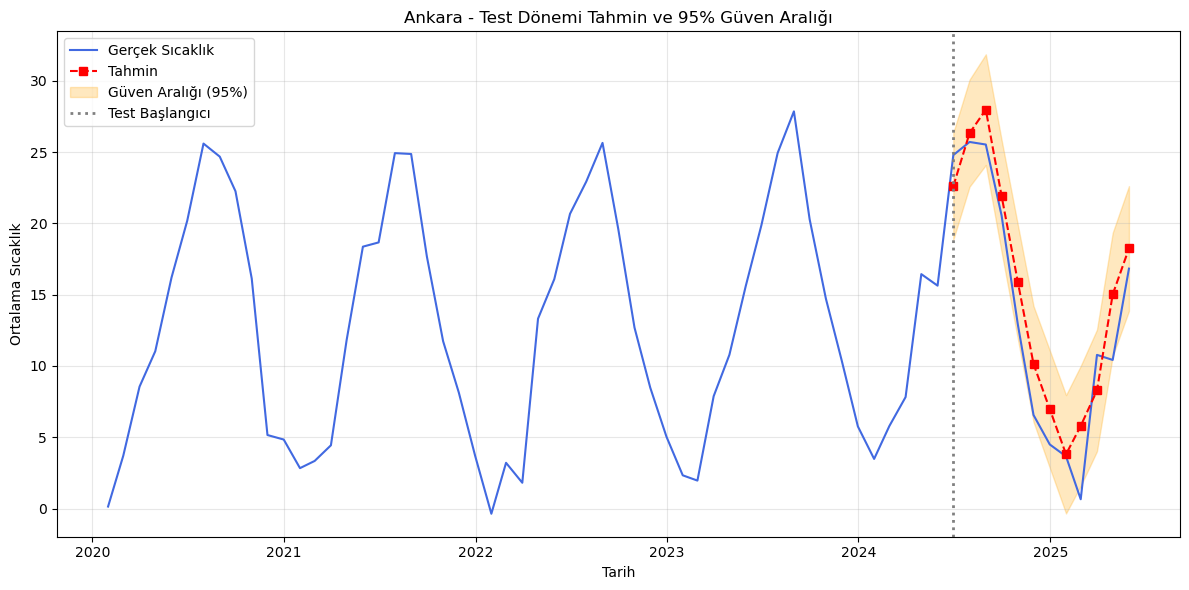

In [13]:
city = "Ankara"   # İster input ile al
sicaklik_tip = "daily_avg_temp"
df_city = df[df["city_name"].str.lower() == city.lower()]

# Aylık ortalamaya çekiyoruz (günlük için de kullanılabilir)
ts = df_city.set_index("date")[sicaklik_tip].resample("ME").mean()
seasonality = 12

ts = ts.dropna()

# Son 12 ayı test olarak bırakıyoruz
test_sayi = 12
egitim = ts[:-test_sayi]
test = ts[-test_sayi:]

# Modeli eğit
model = SARIMAX(egitim, order=(1,1,1), seasonal_order=(1,1,1,seasonality))
model_fit = model.fit(disp=False)

# Tahmin ve güven aralığı al
forecast = model_fit.get_forecast(steps=test_sayi)
tahminler = forecast.predicted_mean
conf_int = forecast.conf_int(alpha=0.05)  # %95 güven aralığı
tahminler.index = test.index
conf_int.index = test.index

# Print ile göster
print("\nTahmin ve Güven Aralığı:")
print(pd.DataFrame({"Tahmin": tahminler, "Alt": conf_int.iloc[:, 0], "Üst": conf_int.iloc[:, 1]}))

# Grafik: Gerçek, Tahmin ve Güven Aralığı
plt.figure(figsize=(12, 6))
plt.plot(ts.index, ts.values, label="Gerçek Sıcaklık", color="royalblue")
plt.plot(tahminler.index, tahminler.values, label="Tahmin", color="red", linestyle="--", marker="s")
plt.fill_between(conf_int.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color="orange", alpha=0.25, label="Güven Aralığı (95%)")
plt.axvline(test.index[0], color="gray", linestyle="dotted", linewidth=2, label="Test Başlangıcı")
plt.legend()
plt.title(f"{city} - Test Dönemi Tahmin ve 95% Güven Aralığı")
plt.xlabel("Tarih")
plt.ylabel("Ortalama Sıcaklık")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [12]:


# 1. Tüm şehir isimleri
sehirler = df["city_name"].unique()
print("Şehirler:", sehirler)

# 2. Veri setindeki minimum ve maksimum tarih
min_tarih = df["date"].min()
max_tarih = df["date"].max()
print(f"Veri setindeki ilk (min) tarih: {min_tarih.date()}")
print(f"Veri setindeki son (max) tarih: {max_tarih.date()}")

# 3. Tüm şehirler için, min ve max tarih ve veri sayısı
print("\nŞehir Bazında Veri Sınırları ve Sayısı:")
for sehir in sehirler:
    df_sehir = df[df["city_name"] == sehir]
    min_t = df_sehir["date"].min()
    max_t = df_sehir["date"].max()
    veri_sayisi = df_sehir.shape[0]
    print(f"{sehir}: {veri_sayisi} satır, {min_t.date()} - {max_t.date()} arası")

# 4. Her gün için veri var mı?
tum_gunler = pd.date_range(min_tarih, max_tarih, freq="D")
eksik_gunler = set(tum_gunler) - set(df["date"])
print(f"\nToplam gün sayısı: {len(tum_gunler)}")
print(f"Veri setindeki toplam satır: {df.shape[0]}")
print(f"Eksik gün sayısı: {len(eksik_gunler)}")
if eksik_gunler:
    print("Veri olmayan örnek gün(ler):", list(eksik_gunler)[:5])  # ilk 5 tanesini göster

# 5. Her şehir için her gün veri var mı?
print("\nHer şehir için eksik gün var mı?")
for sehir in sehirler:
    df_sehir = df[df["city_name"] == sehir]
    sehir_gunler = set(df_sehir["date"])
    eksik = set(tum_gunler) - sehir_gunler
    print(f"{sehir}: {len(eksik)} eksik gün")
    if len(eksik) > 0:
        print(f"  Örnek eksik gün(ler): {list(eksik)[:3]}")



Şehirler: ['Adana' 'Ankara' 'Antalya' 'Bursa' 'Gaziantep' 'İstanbul' 'İzmir'
 'Kocaeli' 'Konya' 'Şanlıurfa']
Veri setindeki ilk (min) tarih: 2020-01-01
Veri setindeki son (max) tarih: 2025-05-31

Şehir Bazında Veri Sınırları ve Sayısı:
Adana: 1978 satır, 2020-01-01 - 2025-05-31 arası
Ankara: 1978 satır, 2020-01-01 - 2025-05-31 arası
Antalya: 1978 satır, 2020-01-01 - 2025-05-31 arası
Bursa: 1978 satır, 2020-01-01 - 2025-05-31 arası
Gaziantep: 1978 satır, 2020-01-01 - 2025-05-31 arası
İstanbul: 1978 satır, 2020-01-01 - 2025-05-31 arası
İzmir: 1978 satır, 2020-01-01 - 2025-05-31 arası
Kocaeli: 1978 satır, 2020-01-01 - 2025-05-31 arası
Konya: 1978 satır, 2020-01-01 - 2025-05-31 arası
Şanlıurfa: 1978 satır, 2020-01-01 - 2025-05-31 arası

Toplam gün sayısı: 1978
Veri setindeki toplam satır: 19780
Eksik gün sayısı: 0

Her şehir için eksik gün var mı?
Adana: 0 eksik gün
Ankara: 0 eksik gün
Antalya: 0 eksik gün
Bursa: 0 eksik gün
Gaziantep: 0 eksik gün
İstanbul: 0 eksik gün
İzmir: 0 eksik gün
K